# Forex Trend Prediction

In [1]:
# Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Dataset Load

df = pd.read_csv(r'C:\Users\Arie\Documents\Portfolio\Forex Trend Analysis Project\Dataset\clean_usdjpy.csv')
df.head()

,datetime,open,high,low,close
0,2025-07-07,144.48300,144.85001,144.22000,144.80800
1,2025-07-04,144.91499,144.97099,144.17999,144.44299
2,2025-07-03,143.65900,145.23399,143.44200,144.90500
3,2025-07-02,143.42900,144.24400,143.31700,143.61000
4,2025-07-01,143.99800,144.05099,142.67599,143.38699


In [4]:
df = df.sort_values(by='datetime', ascending=True).reset_index(drop=True)

In [5]:
df.head()

,datetime,open,high,low,close
0,2006-06-30,115.03,115.24,114.15,114.44
1,2006-07-03,114.31,114.95,114.08,114.69
2,2006-07-04,114.71,114.84,114.36,114.81
3,2006-07-05,114.91,115.80,114.56,115.69
4,2006-07-06,115.67,115.72,114.87,115.13


In [6]:
df.shape

(5000, 5)

In [7]:
usdjpy = df.copy()
usdjpy.head()

,datetime,open,high,low,close
0,2006-06-30,115.03,115.24,114.15,114.44
1,2006-07-03,114.31,114.95,114.08,114.69
2,2006-07-04,114.71,114.84,114.36,114.81
3,2006-07-05,114.91,115.80,114.56,115.69
4,2006-07-06,115.67,115.72,114.87,115.13


# Feature Engineering

In [8]:
# Adding tomorrow price in feature
usdjpy['tomorrow'] = usdjpy['close'].shift(-1)
usdjpy.head()

,datetime,open,high,low,close,tomorrow
0,2006-06-30,115.03,115.24,114.15,114.44,114.69
1,2006-07-03,114.31,114.95,114.08,114.69,114.81
2,2006-07-04,114.71,114.84,114.36,114.81,115.69
3,2006-07-05,114.91,115.80,114.56,115.69,115.13
4,2006-07-06,115.67,115.72,114.87,115.13,114.06


In [9]:
# Setting the target column
# If the tomorrow value is more than the price of today then it will be 1 or indicates an up in price

usdjpy['target'] = (usdjpy['tomorrow'] > usdjpy['close']).astype(int)
usdjpy.head()

,datetime,open,high,low,close,tomorrow,target
0,2006-06-30,115.03,115.24,114.15,114.44,114.69,1
1,2006-07-03,114.31,114.95,114.08,114.69,114.81,1
2,2006-07-04,114.71,114.84,114.36,114.81,115.69,1
3,2006-07-05,114.91,115.80,114.56,115.69,115.13,0
4,2006-07-06,115.67,115.72,114.87,115.13,114.06,0


In [10]:
usdjpy['target'].value_counts()

target
1    2556
0    2444
Name: count, dtype: int64

In [11]:
usdjpy = usdjpy.set_index('datetime')
usdjpy.head()

,open,high,low,close,tomorrow,target
datetime,,,,,,
2006-06-30,115.03,115.24,114.15,114.44,114.69,1
2006-07-03,114.31,114.95,114.08,114.69,114.81,1
2006-07-04,114.71,114.84,114.36,114.81,115.69,1
2006-07-05,114.91,115.80,114.56,115.69,115.13,0
2006-07-06,115.67,115.72,114.87,115.13,114.06,0


In [13]:
# Adding new feature

horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = usdjpy.rolling(horizon).mean()

    ratio_column = f'Close_Ratio{horizon}'
    usdjpy[ratio_column] = usdjpy['close'] / rolling_averages['close']

    trend_column = f'Trend_{horizon}'
    usdjpy[trend_column] = usdjpy.shift(1).rolling(horizon).sum()['target']

    new_predictors += [ratio_column, trend_column]

In [15]:
usdjpy = usdjpy.dropna()
usdjpy.head()

,open,high,low,close,tomorrow,target,Close_Ratio2,Trend_2,Close_Ratio5,Trend_5,Close_Ratio60,Trend_60,Close_Ratio250,Trend_250,Close_Ratio1000,Trend_1000
datetime,,,,,,,,,,,,,,,,
2010-04-30,93.965,94.590,93.835,93.855,94.660,1,0.999414,0.0,1.000789,1.0,1.024550,33.0,1.018151,130.0,0.891169,516.0
2010-05-03,94.120,94.780,93.845,94.660,94.900,1,1.004270,1.0,1.007707,2.0,1.032318,33.0,1.026957,130.0,0.898983,516.0
2010-05-04,94.660,94.975,94.330,94.900,93.880,0,1.001266,2.0,1.006598,3.0,1.033980,33.0,1.029619,131.0,0.901433,516.0
2010-05-05,94.900,94.990,93.540,93.880,91.360,0,0.994597,1.0,0.996053,2.0,1.022132,32.0,1.018583,131.0,0.891929,515.0
2010-05-06,93.880,93.975,87.980,91.360,91.595,1,0.986396,0.0,0.974704,2.0,0.994397,32.0,0.991351,131.0,0.868183,515.0


In [16]:
usdjpy.shape

(3999, 16)

# Model Training
1 = up <br>
0 = down

In [21]:
# Importing Models

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

models = {
    'rfc' : RandomForestClassifier(),
    'gbc' : GradientBoostingClassifier(),
    'knn' : KNeighborsClassifier(),
    'xgb' : xgb.XGBClassifier(),
    'dtc' : DecisionTreeClassifier()
}

In [25]:
# Create a predict function
def predict(train, test, predictors, model):
    model.fit(train[predictors], train['target'])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= .6] = 1
    preds[preds < .6] = 0 
    preds = pd.Series(preds, index=test.index, name='Predictions')
    combined = pd.concat([test['target'], preds], axis=1)
    return combined

In [35]:
# Create a backtest function
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [ ]:
# Model Evaluation Metrics
from sklearn.metrics import precision_score, recall_score, accuracy_score

# Create a function for metrics
def metrics(test, pred):
    accuracy = accuracy_score(test, pred)
    precision = precision_score(test, pred)
    recall = recall_score(test, pred)
    
    result = {
        'Accuracy'  : accuracy,
        'Precision' : precision,
        'Recall'    : recall
    }
    return result

In [36]:
# Training and testing the metrics

model_name = []
accuracy_result = []
precision_result = []

for name, model in models.items():
    predictions = backtest(usdjpy, model, new_predictors)
    accuracy = accuracy_score(predictions['target'], predictions['Predictions'])
    precision = precision_score(predictions['target'], predictions['Predictions'])

    model_name.append(name)
    accuracy_result.append(accuracy*100)
    precision_result.append(precision *100)

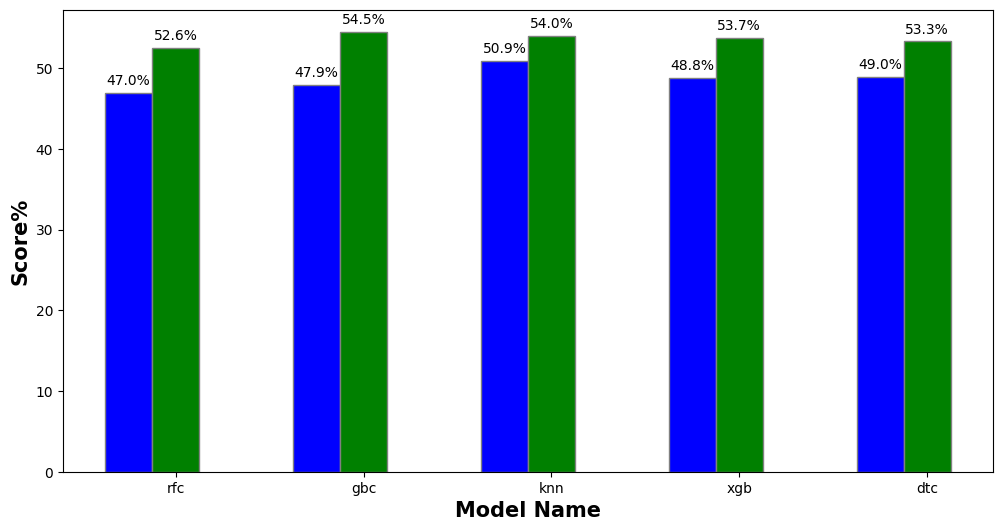

In [37]:
# Visualize the comparison
plt.figure(figsize = (12,6))

barWidth = 0.25
br1 = np.arange(len(accuracy_result)) 
br2 = [x + barWidth for x in br1] 

plt.bar(br1, accuracy_result, color ='b', width = barWidth, 
        edgecolor ='grey', label ='accuracy') 
plt.bar(br2, precision_result, color ='g', width = barWidth, 
        edgecolor ='grey', label ='precision') 

for i in range(len(accuracy_result)):
    plt.text(br1[i], accuracy_result[i] + 1, f'{accuracy_result[i]:.1f}%', ha='center', fontsize=10)
    plt.text(br2[i], precision_result[i] + 1, f'{precision_result[i]:.1f}%', ha='center', fontsize=10)

plt.xlabel('Model Name', fontweight ='bold', fontsize = 15) 
plt.ylabel('Score%', fontweight ='bold', fontsize = 15) 
plt.xticks([r + barWidth for r in range(len(accuracy_result))], 
        model_name)

plt.show()

With the comparison score we can see that GBC have the overall highest score of all the models so we decided to continue with the Gradient Boosting Classifier

# Hyper Parameter Tuning

In [38]:
#Data Splitting

data = usdjpy.copy()
start = 2500
step = 250

# Split point
i = start

# Training data (first i rows)
train = data.iloc[0:i].copy()

# Testing data (next 'step' rows after i)
test = data.iloc[i:i+step].copy()

# Optional: Check shapes
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (2500, 16)
Test shape: (250, 16)


In [39]:
X_test = test[new_predictors]
y_test = test['target']
X_train = train[new_predictors]
y_train = train['target']

In [45]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 3],
    'subsample': [0.8, 1.0],
    'max_features': ['sqrt', 'log2']
}

gb_model = GradientBoostingClassifier()

grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred_best = best_model.predict(X_test)

accuracy_best = accuracy_score(y_test, y_pred_best)

print("Best Parameters:", best_params)
print(f"Best Model Accuracy: {accuracy_best}")

Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150, 'subsample': 0.8}
Best Model Accuracy: 0.484


In [46]:
best_model

GradientBoostingClassifier(learning_rate=0.05, max_depth=5, max_features='log2',
                           min_samples_split=5, n_estimators=150,
                           subsample=0.8)

In [47]:
model = GradientBoostingClassifier()
predictions = backtest(usdjpy, model, new_predictors)
base_model = metrics(predictions['target'], predictions['Predictions'])

In [48]:
model = best_model
predictions = backtest(usdjpy, model, new_predictors)
tuned = metrics(predictions['target'], predictions['Predictions'])

In [49]:
results_df = pd.DataFrame([base_model, tuned], index=['Base Model', 'Tuned Model'])
results_df

,Accuracy,Precision,Recall
Base Model,0.477652,0.542056,0.214815
Tuned Model,0.490994,0.575080,0.222222


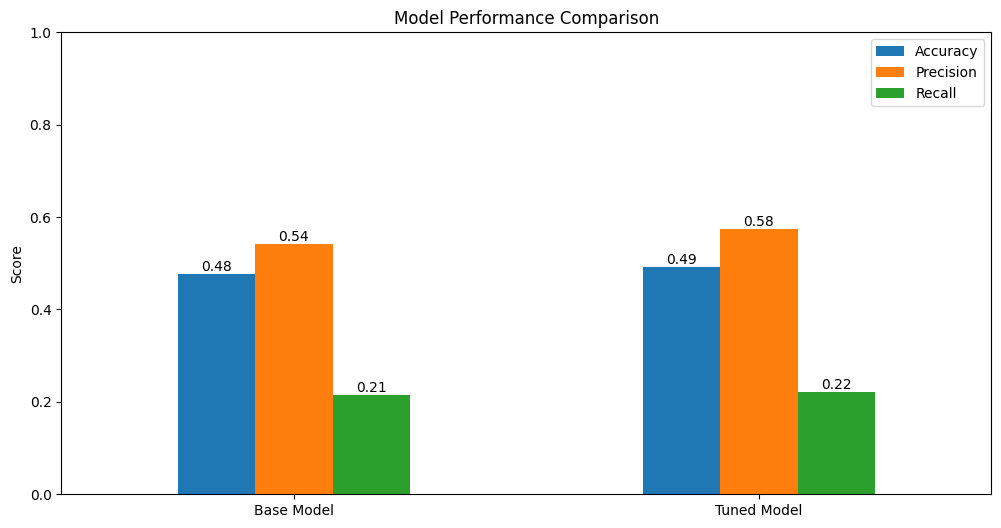

In [50]:
# Visualize the comparison

results_df.plot(kind='bar', figsize=(12, 6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)

# Value Labels
for i in plt.gca().containers:
    plt.bar_label(i, fmt='%.2f', label_type='edge')

plt.legend(loc='upper right')
plt.show()


There is some improvement on all the evaluation metrics after the param tuning

In [51]:
pred = model.predict(usdjpy[new_predictors])

if pred[0] == 1:
    print("Model says: BUY (price will go up)")
else:
    print("Model says: SELL (price will go down)")

Model says: BUY (price will go up)


In [66]:
usdjpy.tail()

,open,high,low,close,tomorrow,target,Close_Ratio2,Trend_2,Close_Ratio5,Trend_5,Close_Ratio60,Trend_60,Close_Ratio250,Trend_250,Close_Ratio1000,Trend_1000
datetime,,,,,,,,,,,,,,,,
2025-06-30,144.47400,144.76199,143.77800,144.02901,143.38699,0,0.997970,1.0,0.996259,3.0,0.999178,30.0,0.964259,132.0,1.020410,564.0
2025-07-01,143.99800,144.05099,142.67599,143.38699,143.61000,1,0.997766,0.0,0.994366,2.0,0.994678,30.0,0.959975,132.0,1.015646,564.0
2025-07-02,143.42900,144.24400,143.31700,143.61000,144.90500,1,1.000777,1.0,0.996939,3.0,0.996183,30.0,0.961493,132.0,1.017011,564.0
2025-07-03,143.65900,145.23399,143.44200,144.90500,144.44299,0,1.004489,2.0,1.005522,3.0,1.004810,31.0,0.970166,132.0,1.025958,564.0
2025-07-04,144.91499,144.97099,144.17999,144.44299,144.80800,1,0.998403,1.0,1.002556,2.0,1.001368,30.0,0.967117,131.0,1.022465,564.0


In [52]:
# Save the model
import joblib

joblib.dump (model, 'gradient_boost_classifier.pkl')

['gradient_boost_classifier.pkl']

In [53]:
usdjpy.to_csv('usdjpy_featured.csv', index=True)